# Global Imports

In order to run the code in this notebook, you need to have TensorFlow and Keras (with TensorFlow backend) installed.

Below are the necessary imports, as well as some helper functions used throughout. Execute these each time you open the notebook.

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

%matplotlib inline
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import sys
from PIL import Image

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6392168621741711010, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3173357977
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7322652100215009856
 physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [2]:
# Needed for resetting a tensorflow graph
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


def random_batch(X_train, y_train, batch_size):
    index_set = np.random.randint(0, X_train.shape[0], batch_size)
    X_batch = X_train[index_set]
    y_batch = y_train[index_set]
    return X_batch, y_batch

def random_batch_1d(X_train, batch_size):
    m = X_train.shape[0]
    index_set = np.random.randint(0, m, batch_size)
    return X_train[index_set]


def plot_image(image, cmap="gray", shape=[28, 28], pad=2):
    image = image - image.min()
    
    if len(image.shape) == 3:
        channels = image.shape[2]
    else:
        channels = 1
        
    if channels == 1:
        plt.imshow(image.reshape(shape), cmap=cmap, interpolation="nearest")
    else:
        plt.imshow(image)
    plt.axis("off")
    
    
def combine_images(images, rows=None, cols=None):
    n_images = images.shape[0]
    shape = images.shape[1:]
    
    if rows == None or cols == None:
        cols = int(math.sqrt(n_images))
        rows = int(math.floor(float(n_images)/cols))
    
    if len(shape) == 3:
        channels = shape[2]
    else:
        channels = 1
    
    if channels == 1:
        image = np.zeros((rows*shape[0], cols*shape[1]), dtype=images.dtype)
    else:
        image = np.zeros((rows*shape[0], cols*shape[1], shape[2]), dtype=images.dtype)
    #print(generated_images.shape, shape, image.shape)
    
    for row in range(rows):
        for col in range(cols):
            img_index = row * cols + col
            img = images[img_index]
            if channels == 1:
                image[
                    row*shape[0]:(row+1)*shape[0], 
                    col*shape[1]:(col+1)*shape[1]
                ] = img.reshape((shape[0], shape[1]))
            else:
                image[
                    row*shape[0]:(row+1)*shape[0], 
                    col*shape[1]:(col+1)*shape[1],
                    :
                ] = img.reshape((shape[0], shape[1], shape[2]))
    return image

# Basic Autoencoders

## Data Import (MNIST)

In [3]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape, y_train.shape)

height = X_train.shape[1]
width = X_train.shape[2]
channels = 1

X_train = X_train.astype(np.float32) / 255.0 #ensure pixel values are between 0 and 1
X_train = X_train.reshape((X_train.shape[0], height, width, channels))
X_test = X_test.astype(np.float32) / 255.0 #ensure pixel values are between 0 and 1
X_test = X_test.reshape((X_test.shape[0], height, width, channels))

# Run this if you don't use the whole training set
if False:
    m = 10000
    random_indeces = np.random.randint(0, X_train.shape[0], np.min(m, X_train.shape[0]))
    X_train = X_train[random_indeces]

print(X_train.shape, X_test.shape)

Using TensorFlow backend.


(60000, 28, 28) (60000,)
(60000, 28, 28, 1) (10000, 28, 28, 1)


## Dense Model `k_auto0`

A dense autoencoder for MNIST consists of a dense neural network with a layout similar to this:
<img src="./images/k_auto0.png" style="width:50%">

In [4]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers.core import Activation, Dense, Flatten, Reshape

n_codings = 16
model_name = 'k_auto0'

encoder_file = 'models/auto/mnist/' + model_name + '-enc'
decoder_file = 'models/auto/mnist/' + model_name + '-dec'
model_file = 'models/auto/mnist/' + model_name + '-model'

image_save_path = "images/mnist/" + model_name + "/"
image0_save_path = "images/mnist/" + model_name + "/0/"

In [5]:
K.clear_session()
n_inputs = height * width * channels


# Build the encoder part of the model
#
encoder = Sequential(name="encoder")

encoder.add(Flatten(input_shape=(height, width, channels, ), name="input"))
encoder.add(Dense(units=250))
encoder.add(Activation('relu'))

# Codings layer - I chose the codings to be between -1 and 1
# but other activations (or no activation) work okay for this model
encoder.add(Dense(units=n_codings))
encoder.add(Activation('tanh', name='codings'))

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               196250    
_________________________________________________________________
activation_1 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                4016      
_________________________________________________________________
codings (Activation)         (None, 16)                0         
Total params: 200,266
Trainable params: 200,266
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Build the decoder part of the model
#
n_outputs = n_inputs

decoder = Sequential(name="decoder")

decoder.add(Dense(units=320, input_shape=(n_codings,), name='codings_in'))
decoder.add(Activation('relu'))
#decoder.add(LeakyReLU(alpha=0.05))

decoder.add(Dense(units=n_outputs))
decoder.add(Activation('sigmoid'))

decoder.add(Reshape(target_shape=(height,width,channels), name='output'))

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
codings_in (Dense)           (None, 320)               5440      
_________________________________________________________________
activation_2 (Activation)    (None, 320)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               251664    
_________________________________________________________________
activation_3 (Activation)    (None, 784)               0         
_________________________________________________________________
output (Reshape)             (None, 28, 28, 1)         0         
Total params: 257,104
Trainable params: 257,104
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Stack the two together
#
# NOTE: this could have all been done in a single sequential model, but I chose
# this approach to be able to feed random values into the decoder later on
#
model = Sequential()
model.add(encoder)
model.add(decoder)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 16)                200266    
_________________________________________________________________
decoder (Sequential)         (None, 28, 28, 1)         257104    
Total params: 457,370
Trainable params: 457,370
Non-trainable params: 0
_________________________________________________________________


### Optimizer

In [8]:
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta

#optimizer = SGD()
#optimizer = SGD(lr=0.005, momentum=0.7, nesterov=True)
optimizer = Adam()
#optimizer = Adam(lr=0.001)
#optimizer = RMSprop()
#optimizer = RMSprop(lr=0.001)
#optimizer = Adagrad()
#optimizer = Adagrad(lr=0.001)
#optimizer = Adadelta(lr=0.15)


encoder.compile(loss='mean_squared_error', optimizer="adam")
decoder.compile(loss='mean_squared_error', optimizer="adam")
model.compile(loss='mean_squared_error', optimizer=optimizer)

### Train / Save / Restore

In [ ]:
epochs = 50
batch_size = 200

history = model.fit(
    X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1
)

score = model.evaluate(X_test, X_test, verbose=1)
print("Test score:", score)

Below is a custom training script that saves image reconstructions at every epoch, allowing us to visualize how the training improves the model over time.

In [ ]:
n_epochs = 50
batch_size = 200
n_batches = X_train.shape[0] // batch_size

see_changes = True #use the same noise for output images, to track changes4
show_zero = False

n_examples = 8
noise_const = np.random.normal(0, 1, n_examples * n_codings).reshape((n_examples, n_codings))
images_const = random_batch_1d(X_train, n_examples)
noise_zero = np.zeros((1, n_codings))

epoch = 0

print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)

while epoch < n_epochs:
    losses = []
    for iteration in range(n_batches):
        if show_zero:
            image0 = combine_images(decoder.predict(noise_zero), 1, 1) * 255
            Image.fromarray(image0.astype(np.uint8)).save(
                    image0_save_path + str(epoch) + "_" + str(iteration) + ".png")
        
        if iteration % (n_batches // 1) == 0:
            images_out = model.predict(images_const)
            images = np.r_[images_const, images_out]
            image = combine_images(images, rows=2, cols=n_examples)
            image = image * 255
            Image.fromarray(image.astype(np.uint8)).save(
                image_save_path + str(epoch) + "_" + str(iteration) + ".png")
        
        X_batch = random_batch_1d(X_train, batch_size)
        
        loss = model.train_on_batch(x=X_batch, y=X_batch)
        losses.append(loss)
        loss_stat = np.std(losses)
        
        if iteration % (n_batches // 20) == 0:
            print("\rEpoch {:3}: {:3}% | loss: {:2.4f} | stdev: {:2.5f}".format(
                    epoch, 100 * iteration // n_batches, loss, loss_stat), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
    # Save one last image at the very end
    if epoch == n_epochs:
        images_out = model.predict(images_const)
        images = np.r_[images_const, images_out]
        image = combine_images(images, rows=2, cols=n_examples)
        image = image * 255
        Image.fromarray(image.astype(np.uint8)).save(
            image_save_path + str(epoch) + "_" + str(iteration) + ".png")

print("Training finished.")

score = model.evaluate(X_test, X_test, verbose=0)
print("Test score:", score)

In [ ]:
# Save the encoder, decoder, and stacked models
#
encoder.save(encoder_file + '.h5')
decoder.save(decoder_file + '.h5')
model.save(model_file + '.h5')

In [9]:
from keras.models import load_model

# Restore a saved model if it exists
#
encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')
model= load_model(model_file + '.h5')

### Reconstruction Output

Let's take a look at how well the reconstructions look:

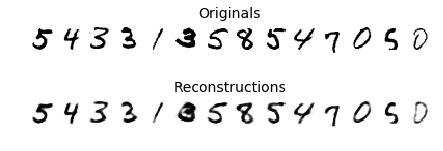

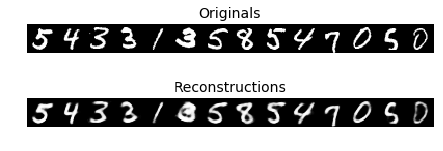

In [10]:
n_digits = 14
cols = n_digits
rows = 1
scaling_factor = 1.1

images_in, _ = random_batch(X_test, y_test, batch_size=n_digits)
images_out = model.predict(images_in)

image_in = combine_images(images_in, rows, cols)
image_out = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(scaling_factor*cols, scaling_factor*rows*2))
plt.subplot(2,1,1)
plt.title("Originals", fontsize=14)
plt.imshow(image_in, cmap="Greys", interpolation="nearest")
plt.axis("off")

plt.subplot(2,1,2)
plt.title("Reconstructions", fontsize=14)
plt.imshow(image_out, cmap="Greys", interpolation="nearest")
plt.axis("off")

plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(scaling_factor*cols, scaling_factor*rows*2))
plt.subplot(2,1,1)
plt.title("Originals", fontsize=14)
plt.imshow(image_in, cmap="gray", interpolation="nearest")
plt.axis("off")

plt.subplot(2,1,2)
plt.title("Reconstructions", fontsize=14)
plt.imshow(image_out, cmap="gray", interpolation="nearest")
plt.axis("off")

plt.tight_layout()
plt.show()

The reconstructions look slightly blurry, but overall good. We might be able to get away with a smaller dimensional coding space!

### Generative

One thing to try is to feed a randomly generated encoding vector into the decoder. Let's see what we get if we use the model `k_auto0`:

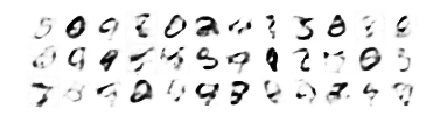

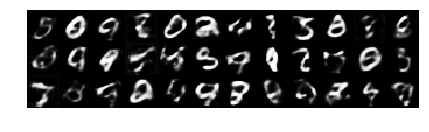

In [11]:
rows = 3
cols = 12
n_images = rows * cols
scaling_factor = 0.6

#codings_in = np.random.uniform(0, 1, n_images * n_codings).reshape((n_images, n_codings))
codings_in = np.random.normal(0, 0.33, n_images * n_codings).reshape((n_images, n_codings))
images_out = decoder.predict(codings_in)

image = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(scaling_factor*cols, scaling_factor*rows))
plt.imshow(image, cmap="Greys", interpolation='nearest')
plt.axis("off")
plt.show()

fig = plt.figure(figsize=(scaling_factor*cols, scaling_factor*rows))
plt.imshow(image, cmap="gray", interpolation='nearest')
plt.axis("off")
plt.show()

### Encoding Distributions

In [12]:
X_encoded = encoder.predict(X_train, verbose=True)
print(X_encoded.shape)

60000/60000 [==============================] - 2s 33us/step
(60000, 16)


Let's plot a few of the encoded vectors' coodinates:

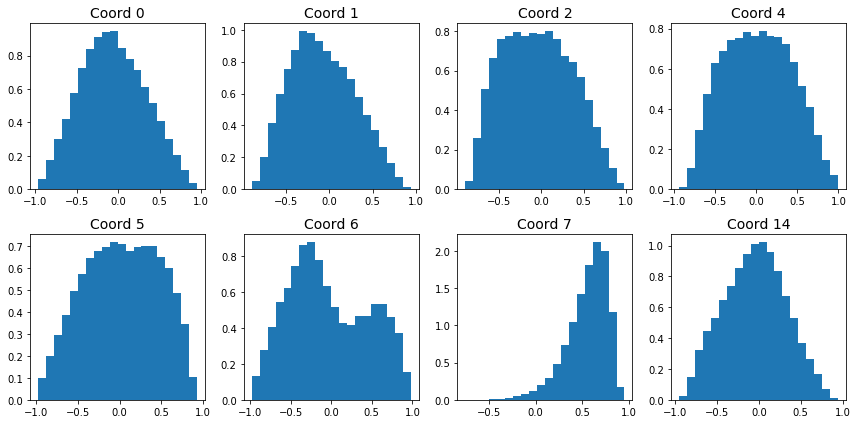

In [13]:
showAll = False

coord_indeces = np.array([
    [ 0, 1, 2, 4],
    [ 5, 6, 7, 14]
])

if showAll:
    n_cols = 4
    n_rows = X_encoded.shape[1] // n_cols
else:
    n_cols = coord_indeces.shape[1]
    n_rows = coord_indeces.shape[0]

plt.figure(figsize=(12, int(12.0/n_cols * n_rows)))
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        if showAll:
            plt.title("Coord " + str(i), fontsize=14)
            plt.hist(X_encoded[:, i], bins=20, density=True)
        else:
            plt.title("Coord " + str(coord_indeces[row, col]), fontsize=14)
            plt.hist(X_encoded[:, coord_indeces[row, col]], bins=20, density=True)
plt.tight_layout()
plt.show()

The distributions of the coordinates are all different. No wonder feeding in a random encoding vector with coordinates sampled from a gaussian distribution didn't generate anything legible!

*Variational autoencoders* solve this problem.

## PCA visualization

### 2D

In [14]:
from keras.models import load_model

model_name = 'k_auto0'

encoder_file = 'models/auto/mnist/' + model_name + '-enc'
decoder_file = 'models/auto/mnist/' + model_name + '-dec'

encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')

n_codings = encoder.layers[-1].output_shape[1]
print(n_codings)

16


In [15]:
n_points = 3000
X_batch, y_batch = random_batch(X_train, y_train, n_points)
X_enc = encoder.predict(X_batch)

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2d = pca.fit_transform(X_enc)
print("Compressed", X_enc.shape, "into", X2d.shape)

Compressed (3000, 16) into (3000, 2)


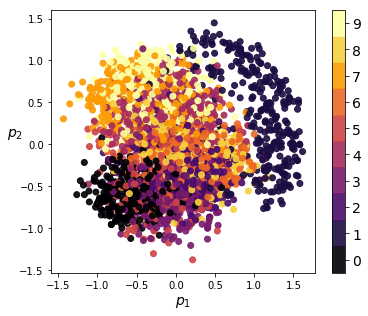

In [17]:
fig = plt.figure(figsize=(5.5,4.5))

colors = y_batch
colormap = plt.get_cmap('inferno', 10)

p = plt.scatter(X2d[:, 0], X2d[:, 1],
        c=colors, cmap=colormap, marker='o', alpha=0.9
)

plt.xlabel("$p_1$", fontsize=14)
plt.ylabel("$p_2$", fontsize=14).set_rotation(0)
plt.axis('tight')

cbar = fig.colorbar(p)
# The color bar values range from 0 to 9 (10 total values), and
# each data point should have a label located at the middle of each bin.
# The bins are: 0.5*(9.0/10.0), 1.5*(9.0/10.0), etc.
tick_labels = [d for d in range(10)]
tick_locations = []
for i in tick_labels:
    tick_locations.append(  (i + 0.5)*(9.0/10.0)  ) 
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
fig_save_path = "images/" + model_name + "_pca2d-all.png"
plt.savefig(fig_save_path, transparent=True) #dpi=100
plt.show()

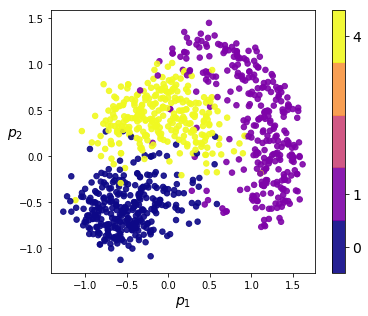

In [18]:
digit_list = [0, 1, 4]

n_digits = len(digit_list)
digit_min = min(digit_list)
digit_max = max(digit_list)
digit_range = np.float(digit_max - digit_min)

n_bins = digit_range + 1
delta = digit_range/(digit_range+1.0)

index_list = []
for d in digit_list:
    index_list.append(y_batch == d)
indeces = (sum(index_list) == 1)

plt.figure(figsize=(5.5,4.5))

colors = y_batch[indeces]
colormap = plt.get_cmap('plasma', n_bins)

p = plt.scatter(X2d[indeces, 0], X2d[indeces, 1], 
        s=30, c=colors, cmap=colormap, marker='o', alpha=0.9
)
plt.xlabel("$p_1$", fontsize=14)
plt.ylabel("$p_2$", fontsize=14).set_rotation(0)
plt.axis('tight')

cbar = plt.colorbar(p)
tick_labels = digit_list
tick_locations = []
for i in range(n_digits):
    tick_locations.append(  digit_min + delta/2.0 + (tick_labels[i] - digit_min) * delta  )
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
#fig_save_path = "images/" + model_name + "_pca2d-some.png"
#plt.savefig(fig_save_path, transparent=True) #dpi=100
plt.show()

`KernelPCA` gives us different kernels to work with. Here are some common kernels:
* Linear: $K(\mathbf{a}, \mathbf{b}) = \mathbf{a}^T \cdot \mathbf{b}$
* Polynomial: $K(\mathbf{a}, \mathbf{b}) = (\gamma\mathbf{a}^T \cdot \mathbf{b} + r)^d$
* Gaussian RBF: $K(\mathbf{a}, \mathbf{b}) = \exp(-\gamma \|\mathbf{a}^T - \mathbf{b}\|^2)$
* Sigmoid: $K(\mathbf{a}, \mathbf{b}) = \tanh(\gamma\mathbf{a}^T \cdot \mathbf{b} + r)$

Options:
* `n_components` : int, default=None
* `kernel=` : “linear” | “poly” | “rbf” | “sigmoid” | “cosine” | “precomputed”
* `gamma` : float, default=1/n_features
* `degree` : int, default=3 (for poly kernels)
* `coef0` : float, default=1 (independent term in poly and sigmoid kernels, ignored by other kernels)


In [19]:
from sklearn.decomposition import KernelPCA

pca = KernelPCA(n_components=2, kernel='poly', gamma=0.15, degree=2)
X2d = pca.fit_transform(X_enc)
print("Compressed", X_enc.shape, "into", X2d.shape)

Compressed (3000, 16) into (3000, 2)


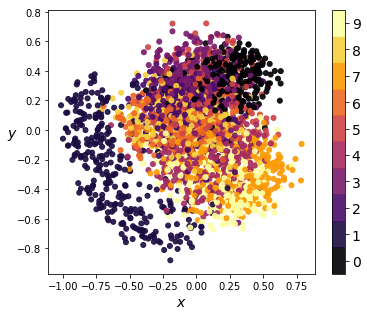

In [20]:
digit_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

n_digits = len(digit_list)
digit_min = min(digit_list)
digit_max = max(digit_list)
digit_range = np.float(digit_max - digit_min)

n_bins = digit_range + 1
delta = digit_range/(digit_range+1.0)

index_list = []
for d in digit_list:
    index_list.append(y_batch == d)
indeces = (sum(index_list) == 1)

plt.figure(figsize=(5.5, 4.5))

colors = y_batch[indeces]
colormap = plt.get_cmap('inferno', n_bins)

p = plt.scatter(X2d[indeces, 0], X2d[indeces, 1], 
        s=25, c=colors, cmap=colormap, marker='o', alpha=0.9
)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14).set_rotation(0)
#plt.xlim((-1, 1))
#plt.ylim((-1, 1))
plt.axis('tight')

cbar = plt.colorbar(p)
tick_labels = digit_list
tick_locations = []
for i in range(n_digits):
    tick_locations.append(  digit_min + delta/2.0 + (tick_labels[i] - digit_min) * delta  )
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
fig_save_path = "images/" + model_name + "_kerpca2d-all.png"
plt.savefig(fig_save_path, transparent=True) #dpi=100
plt.show()

### 3D

In [21]:
from keras.models import load_model

#model_name = 'k_auto1'
model_name = 'k_auto0'

encoder_file = 'models/auto/mnist/' + model_name + '-enc'
decoder_file = 'models/auto/mnist/' + model_name + '-dec'

encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')

n_codings = encoder.layers[-1].output_shape[1]
print(n_codings)

16


In [22]:
n_points = 3000
X_batch, y_batch = random_batch(X_train, y_train, n_points)
X_enc = encoder.predict(X_batch)

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X3d = pca.fit_transform(X_enc)
print("Compressed", X_enc.shape, "into", X3d.shape)

Compressed (3000, 16) into (3000, 3)


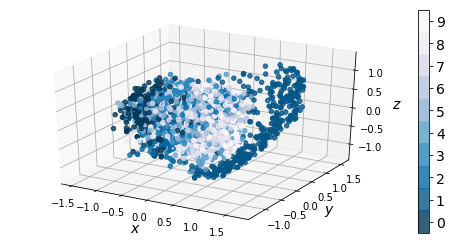

In [24]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7,3.5))
ax3d = fig.add_subplot(111, projection='3d')

colors = y_batch# / 9.0
colormap = plt.get_cmap('PuBu_r', 10)

p = ax3d.scatter3D(
        X3d[:, 0], X3d[:, 1], X3d[:, 2],
        c=colors, cmap=colormap, marker='o', alpha=0.8
)

ax3d.set_xlabel("$x$", fontsize=14)
ax3d.set_ylabel("$y$", fontsize=14)
ax3d.set_zlabel("$z$", fontsize=14)
ax3d.axis('tight')

cbar = fig.colorbar(p)
tick_labels = [d for d in range(10)]
tick_locations = []
for i in tick_labels:
    tick_locations.append(  (i + 0.5)*(9.0/10.0)  ) 
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
fig_save_path = "images/" + model_name + "_pca3d-all.png"
plt.savefig(fig_save_path, transparent=True) #dpi=100
plt.show()

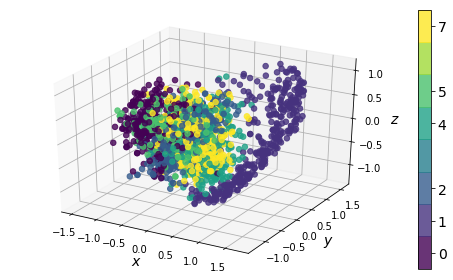

In [25]:
from mpl_toolkits.mplot3d import Axes3D

digit_list = [0, 1, 2, 4, 5, 7]

n_digits = len(digit_list)
digit_min = min(digit_list)
digit_max = max(digit_list)
digit_range = np.float(digit_max - digit_min)

n_bins = digit_range + 1
delta = digit_range/(digit_range+1.0)

index_list = []
for d in digit_list:
    index_list.append(y_batch == d)
indeces = (sum(index_list) == 1)

fig = plt.figure(figsize=(7,4))
ax3d = fig.add_subplot(111, projection='3d')

colors = y_batch[indeces]
colormap = plt.get_cmap('viridis', n_bins)

p = ax3d.scatter3D(X3d[:, 0][indeces], X3d[:, 1][indeces], X3d[:, 2][indeces],
        s=30, c=colors, cmap=colormap, marker='o', alpha=0.8
)
ax3d.set_xlabel("$x$", fontsize=14)
ax3d.set_ylabel("$y$", fontsize=14)
ax3d.set_zlabel("$z$", fontsize=14)
ax3d.axis('tight')

cbar = fig.colorbar(p)
tick_labels = digit_list
tick_locations = []
for i in range(n_digits):
    tick_locations.append(  digit_min + delta/2.0 + (tick_labels[i] - digit_min) * delta  )
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
#fig_save_path = "images/" + model_name + "_pca3d-some.png"
#plt.savefig(fig_save_path, transparent=True) #dpi=100
plt.show()

`KernelPCA` gives us different kernels to work with. Here are some common kernels:
* Linear: $K(\mathbf{a}, \mathbf{b}) = \mathbf{a}^T \cdot \mathbf{b}$
* Polynomial: $K(\mathbf{a}, \mathbf{b}) = (\gamma\mathbf{a}^T \cdot \mathbf{b} + r)^d$
* Gaussian RBF: $K(\mathbf{a}, \mathbf{b}) = \exp(-\gamma \|\mathbf{a}^T - \mathbf{b}\|^2)$
* Sigmoid: $K(\mathbf{a}, \mathbf{b}) = \tanh(\gamma\mathbf{a}^T \cdot \mathbf{b} + r)$

Options:
* `n_components` : int, default=None
* `kernel=` : “linear” | “poly” | “rbf” | “sigmoid” | “cosine” | “precomputed”
* `gamma` : float, default=1/n_features
* `degree` : int, default=3 (for poly kernels)
* `coef0` : float, default=1 (independent term in poly and sigmoid kernels, ignored by other kernels)


In [26]:
from sklearn.decomposition import KernelPCA

pca = KernelPCA(n_components=3, kernel='poly', gamma=0.18, degree=5, random_state=2)
X3d = pca.fit_transform(X_enc)
print("Compressed", X_enc.shape, "into", X3d.shape)

Compressed (3000, 16) into (3000, 3)


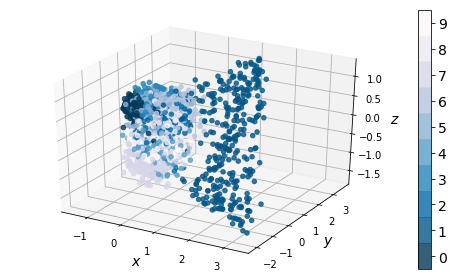

In [27]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7,4))
ax3d = fig.add_subplot(111, projection='3d')

colors = y_batch# / 9.0
colormap = plt.get_cmap('PuBu_r', 10)

p = ax3d.scatter3D(X3d[:, 0], X3d[:, 1], X3d[:, 2],
        c=colors, cmap=colormap, marker='o', alpha=0.8
)

ax3d.set_xlabel("$x$", fontsize=14)
ax3d.set_ylabel("$y$", fontsize=14)
ax3d.set_zlabel("$z$", fontsize=14)
#ax.set_xlim([xmin, xmax])
#ax.set_ylim([ymin, ymax])
#ax.set_zlim([zmin, zmax])
ax3d.axis('tight')

cbar = fig.colorbar(p)
tick_labels = [d for d in range(10)]
tick_locations = []
for i in tick_labels:
    tick_locations.append(  (i + 0.5)*(9.0/10.0)  ) 
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
fig_save_path = "images/" + model_name + "_kerpca3d-all.png"
plt.savefig(fig_save_path, transparent=True) #dpi=100
plt.show()

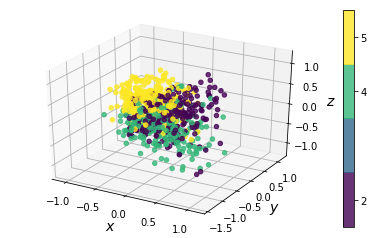

In [28]:
from mpl_toolkits.mplot3d import Axes3D

digit_list = [2, 4, 5]

n_digits = len(digit_list)
digit_min = min(digit_list)
digit_max = max(digit_list)
digit_range = np.float(digit_max - digit_min)

n_bins = digit_range + 1
delta = digit_range/(digit_range+1.0)

index_list = []
for d in digit_list:
    index_list.append(y_batch == d)
indeces = (sum(index_list) == 1)

fig = plt.figure(figsize=(7,4))
ax3d = fig.add_subplot(111, projection='3d')

colors = y_batch[indeces]
colormap = plt.get_cmap('viridis', n_bins)

p = ax3d.scatter3D(X3d[:, 0][indeces], X3d[:, 1][indeces], X3d[:, 2][indeces],
        c=colors, cmap=colormap, marker='o', alpha=0.8
)
ax3d.set_xlabel("$x$", fontsize=14)
ax3d.set_ylabel("$y$", fontsize=14)
ax3d.set_zlabel("$z$", fontsize=14)
#ax.set_xlim([xmin, xmax])
#ax.set_ylim([ymin, ymax])
#ax.set_zlim([zmin, zmax])
ax3d.axis('tight')

cbar = fig.colorbar(p)
tick_labels = digit_list
tick_locations = []
for i in range(n_digits):
    tick_locations.append(  digit_min + delta/2.0 + (tick_labels[i] - digit_min) * delta  )
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()

## Conv Model `k_auto_conv1`

In [29]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers.core import Activation, Dense, Flatten, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D

n_codings = 16
model_name = 'k_auto_conv1'

encoder_file = 'models/auto/mnist/' + model_name + '-enc'
decoder_file = 'models/auto/mnist/' + model_name + '-dec'
model_file = 'models/auto/mnist/' + model_name + '-model'

image_save_path = "images/mnist/" + model_name + "/"
image0_save_path = "images/mnist/" + model_name + "/0/"

In [30]:
K.clear_session()

# Build the encoder part of the model
#
encoder = Sequential(name="encoder")

encoder.add(Conv2D(input_shape=(height,width,channels),
                   filters=4, kernel_size=5, strides=1, padding='same')
)
encoder.add(Activation('relu'))
encoder.add(MaxPooling2D(pool_size=(2, 2)))

encoder.add(Conv2D(filters=8, kernel_size=5, strides=1, padding='same'))
encoder.add(Activation('relu'))
encoder.add(MaxPooling2D(pool_size=(2, 2)))

encoder.add(Flatten())

encoder.add(Dense(units=150))
encoder.add(Activation('relu'))

encoder.add(Dense(units=n_codings))
encoder.add(Activation('tanh', name='output'))

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 4)         104       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 4)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         808       
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 8)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 392)               0         
__________

In [31]:
print(encoder.layers[-1].output_shape[1:])
print(encoder.layers[-2].output_shape)
print(encoder.layers[-3].output_shape)
print(encoder.layers[-4].output_shape)
print(encoder.layers[-5].output_shape)
print(encoder.layers[-6].output_shape)

(16,)
(None, 16)
(None, 150)
(None, 150)
(None, 392)
(None, 7, 7, 8)


In [32]:
# Build the decoder part of the model
#
decoder = Sequential(name="decoder")

decoder.add(Dense(input_shape=(n_codings, ), units=120, name='codings_in'))
decoder.add(Activation('relu'))
decoder.add(Dense(units=320))
decoder.add(Activation('relu'))

h0 = encoder.layers[-6].output_shape[1]
w0 = encoder.layers[-6].output_shape[2]
feats = 16
decoder.add(Dense(units=h0*w0*feats))
decoder.add(Activation('relu'))

decoder.add(Reshape(target_shape=(h0, w0, feats,)))

decoder.add(UpSampling2D(size=(2,2)))
decoder.add(Conv2D(filters=8, kernel_size=5, strides=1, padding='same'))
decoder.add(Activation('relu'))

decoder.add(UpSampling2D(size=(2,2)))
decoder.add(Conv2D(filters=4, kernel_size=6, strides=1, padding='same'))
decoder.add(Activation('relu'))

decoder.add(Conv2D(filters=1, kernel_size=7, strides=1, padding='same'))
decoder.add(Activation('sigmoid', name='output'))

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
codings_in (Dense)           (None, 120)               2040      
_________________________________________________________________
activation_4 (Activation)    (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 320)               38720     
_________________________________________________________________
activation_5 (Activation)    (None, 320)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)               251664    
_________________________________________________________________
activation_6 (Activation)    (None, 784)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 16)          0         
__________

In [33]:
# Stack the two together
#
# NOTE: this could have all been done in a single sequential model, but I chose
# this approach to be able to feed random values into the decoder and see what happens
#
model = Sequential()
model.add(encoder)
model.add(decoder)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 16)                62278     
_________________________________________________________________
decoder (Sequential)         (None, 28, 28, 1)         296985    
Total params: 359,263
Trainable params: 359,263
Non-trainable params: 0
_________________________________________________________________


### Optimizer

In [34]:
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta

#optimizer = SGD()
#optimizer = SGD(lr=0.003, momentum=0.7, nesterov=True)
optimizer = Adam()
#optimizer = Adam(lr=0.001)
#optimizer = RMSprop()
#optimizer = RMSprop(lr=0.001)
#optimizer = Adagrad()
#optimizer = Adagrad(lr=0.001)
#optimizer = Adadelta(lr=0.15)


encoder.compile(loss='mean_squared_error', optimizer="adam")
decoder.compile(loss='mean_squared_error', optimizer="adam")
model.compile(loss='mean_squared_error', optimizer=optimizer)

### Train / Save / Restore

In [ ]:
epochs = 20
batch_size = 150

history = model.fit(
    X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1
)

score = model.evaluate(X_test, X_test, verbose=1)
print("Test score:", score)

In [ ]:
n_epochs = 10
batch_size = 150
n_batches = X_train.shape[0] // batch_size

see_changes = True #use the same noise for output images, to track changes4
show_zero = False

n_examples = 8
noise_const = np.random.normal(0, 1, n_examples * n_codings).reshape((n_examples, n_codings))
images_const = random_batch_1d(X_train, n_examples)
noise_zero = np.zeros((1, n_codings))

epoch = 0

print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)

while epoch < n_epochs:
    losses = []
    for iteration in range(n_batches):
        if show_zero:
            image0 = combine_images(decoder.predict(noise_zero), 1, 1) * 255
            Image.fromarray(image0.astype(np.uint8)).save(
                    image0_save_path + str(epoch) + "_" + str(iteration) + ".png")
        
        if iteration % (n_batches // 20) == 0:
            images_out = model.predict(images_const)
            images = np.r_[images_const, images_out]
            image = combine_images(images, rows=2, cols=n_examples)
            image = image * 255
            Image.fromarray(image.astype(np.uint8)).save(
                image_save_path + str(epoch) + "_" + str(iteration) + ".png")
        
        X_batch = random_batch_1d(X_train, batch_size)
        
        loss = model.train_on_batch(x=X_batch, y=X_batch)
        losses.append(loss)
        loss_stat = np.std(losses)
        
        if iteration % (n_batches // 20) == 0:
            print("\rEpoch {:3}: {:3}% | loss: {:2.4f} | stdev: {:2.5f}".format(
                    epoch, 100 * iteration // n_batches, loss, loss_stat), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
    # Save one last image at the very end
    if epoch == n_epochs:
        images_out = model.predict(images_const)
        images = np.r_[images_const, images_out]
        image = combine_images(images, rows=2, cols=n_examples)
        image = image * 255
        Image.fromarray(image.astype(np.uint8)).save(
            image_save_path + str(epoch) + "_" + str(iteration) + ".png")

print("Training finished.")

score = model.evaluate(X_test, X_test, verbose=0)
print("Test score:", score)

In [ ]:
# Save the encoder, decoder, and stacked models
#
encoder.save(encoder_file + '.h5')
decoder.save(decoder_file + '.h5')
model.save(model_file + '.h5')

In [35]:
from keras.models import load_model

# Restore a saved model if it exists
#
encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')
model= load_model(model_file + '.h5')

### Reconstruction Output

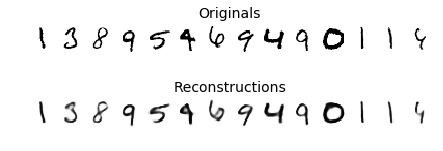

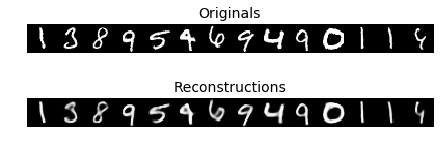

In [36]:
n_digits = 14
cols = n_digits
rows = 1
scaling_factor = 1.1

images_in, _ = random_batch(X_test, y_test, batch_size=n_digits)
images_out = model.predict(images_in)

image_in = combine_images(images_in, rows, cols)
image_out = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(scaling_factor*cols, scaling_factor*rows*2))
plt.subplot(2,1,1)
plt.title("Originals", fontsize=14)
plt.imshow(image_in, cmap="Greys", interpolation="nearest")
plt.axis("off")

plt.subplot(2,1,2)
plt.title("Reconstructions", fontsize=14)
plt.imshow(image_out, cmap="Greys", interpolation="nearest")
plt.axis("off")

plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(scaling_factor*cols, scaling_factor*rows*2))
plt.subplot(2,1,1)
plt.title("Originals", fontsize=14)
plt.imshow(image_in, cmap="gray", interpolation="nearest")
plt.axis("off")

plt.subplot(2,1,2)
plt.title("Reconstructions", fontsize=14)
plt.imshow(image_out, cmap="gray", interpolation="nearest")
plt.axis("off")

plt.tight_layout()
plt.show()

### Generative

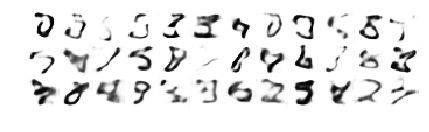

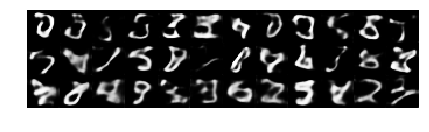

In [37]:
rows = 3
cols = 12
n_images = rows * cols
scaling_factor = 0.6

#codings_in = np.random.uniform(0, 1, n_images * n_codings).reshape((n_images, n_codings))
codings_in = np.random.normal(0, 0.33, n_images * n_codings).reshape((n_images, n_codings))
images_out = decoder.predict(codings_in)

image = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(scaling_factor*cols, scaling_factor*rows))
plt.imshow(image, cmap="Greys", interpolation='nearest')
plt.axis("off")
plt.show()

fig = plt.figure(figsize=(scaling_factor*cols, scaling_factor*rows))
plt.imshow(image, cmap="gray", interpolation='nearest')
plt.axis("off")
plt.show()

### Encoding Distributions

In [38]:
X_encoded = encoder.predict(X_train, verbose=True)
print(X_encoded.shape)

60000/60000 [==============================] - 3s 48us/step
(60000, 16)


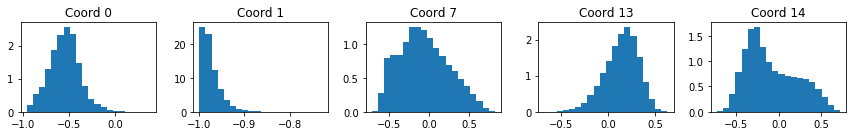

In [39]:
showAll = False

coord_indeces = np.array([
    [  0,  1,  7,  13, 14]
])

if showAll:
    n_cols = 4
    n_rows = X_encoded.shape[1] // n_cols
else:
    n_cols = coord_indeces.shape[1]
    n_rows = coord_indeces.shape[0]

plt.figure(figsize=(12, int(12.0/n_cols * n_rows)))
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        if showAll:
            plt.title("Coord " + str(i))
            plt.hist(X_encoded[:, i], bins=20, density=True)
        else:
            plt.title("Coord " + str(coord_indeces[row, col]))
            plt.hist(X_encoded[:, coord_indeces[row, col]], bins=20, density=True)
plt.tight_layout()
plt.show()

## PCA visualization

### 2D

In [40]:
from keras.models import load_model

model_name = 'k_auto_conv1'

encoder_file = 'models/auto/mnist/' + model_name + '-enc'
decoder_file = 'models/auto/mnist/' + model_name + '-dec'

encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')

n_codings = encoder.layers[-1].output_shape[1]
print(n_codings)

16


In [41]:
n_points = 3000
X_batch, y_batch = random_batch(X_train, y_train, n_points)
X_enc = encoder.predict(X_batch)

In [42]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2d = pca.fit_transform(X_enc)
print("Compressed", X_enc.shape, "into", X2d.shape)

Compressed (3000, 16) into (3000, 2)


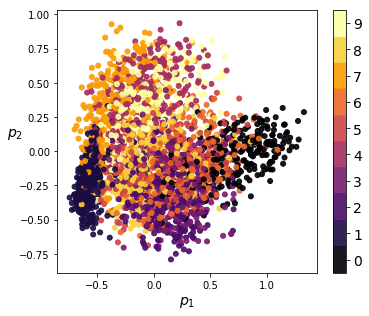

In [43]:
fig = plt.figure(figsize=(5.5,4.5))

colors = y_batch
colormap = plt.get_cmap('inferno', 10)

p = plt.scatter(X2d[:, 0], X2d[:, 1],
        s=25, c=colors, cmap=colormap, marker='o', alpha=0.9
)

plt.xlabel("$p_1$", fontsize=14)
plt.ylabel("$p_2$", fontsize=14).set_rotation(0)
plt.axis('tight')

cbar = fig.colorbar(p)
# The color bar values range from 0 to 9 (10 total values), and
# each data point should have a label located at the middle of each bin.
# The bins are: 0.5*(9.0/10.0), 1.5*(9.0/10.0), etc.
tick_labels = [d for d in range(10)]
tick_locations = []
for i in tick_labels:
    tick_locations.append(  (i + 0.5)*(9.0/10.0)  ) 
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
fig_save_path = "images/" + model_name + "_pca2d-all.png"
plt.savefig(fig_save_path, transparent=True) #dpi=100
plt.show()

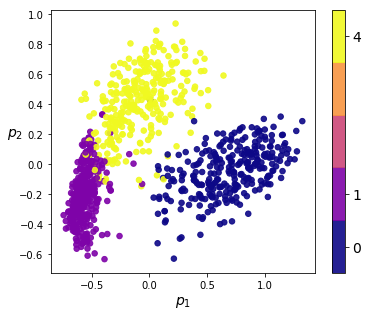

In [44]:
digit_list = [0, 1, 4]

n_digits = len(digit_list)
digit_min = min(digit_list)
digit_max = max(digit_list)
digit_range = np.float(digit_max - digit_min)

n_bins = digit_range + 1
delta = digit_range/(digit_range+1.0)

index_list = []
for d in digit_list:
    index_list.append(y_batch == d)
indeces = (sum(index_list) == 1)

plt.figure(figsize=(5.5,4.5))

colors = y_batch[indeces]
colormap = plt.get_cmap('plasma', n_bins)

p = plt.scatter(X2d[indeces, 0], X2d[indeces, 1], 
        s=30, c=colors, cmap=colormap, marker='o', alpha=0.9
)
plt.xlabel("$p_1$", fontsize=14)
plt.ylabel("$p_2$", fontsize=14).set_rotation(0)
plt.axis('tight')

cbar = plt.colorbar(p)
tick_labels = digit_list
tick_locations = []
for i in range(n_digits):
    tick_locations.append(  digit_min + delta/2.0 + (tick_labels[i] - digit_min) * delta  )
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
#fig_save_path = "images/" + model_name + "_pca2d-some.png"
#plt.savefig(fig_save_path, transparent=True) #dpi=100
plt.show()

`KernelPCA` gives us different kernels to work with. Here are some common kernels:
* Linear: $K(\mathbf{a}, \mathbf{b}) = \mathbf{a}^T \cdot \mathbf{b}$
* Polynomial: $K(\mathbf{a}, \mathbf{b}) = (\gamma\mathbf{a}^T \cdot \mathbf{b} + r)^d$
* Gaussian RBF: $K(\mathbf{a}, \mathbf{b}) = \exp(-\gamma \|\mathbf{a}^T - \mathbf{b}\|^2)$
* Sigmoid: $K(\mathbf{a}, \mathbf{b}) = \tanh(\gamma\mathbf{a}^T \cdot \mathbf{b} + r)$

Options:
* `n_components` : int, default=None
* `kernel=` : “linear” | “poly” | “rbf” | “sigmoid” | “cosine” | “precomputed”
* `gamma` : float, default=1/n_features
* `degree` : int, default=3 (for poly kernels)
* `coef0` : float, default=1 (independent term in poly and sigmoid kernels, ignored by other kernels)


In [45]:
from sklearn.decomposition import KernelPCA

pca = KernelPCA(n_components=2, kernel='poly', gamma=0.15, degree=2)
X2d = pca.fit_transform(X_enc)
print("Compressed", X_enc.shape, "into", X2d.shape)

Compressed (3000, 16) into (3000, 2)


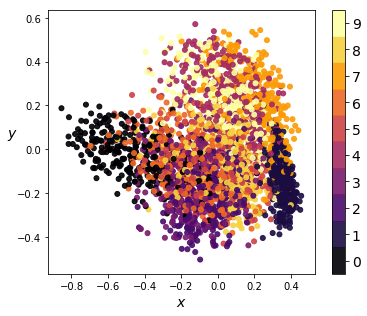

In [46]:
digit_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

n_digits = len(digit_list)
digit_min = min(digit_list)
digit_max = max(digit_list)
digit_range = np.float(digit_max - digit_min)

n_bins = digit_range + 1
delta = digit_range/(digit_range+1.0)

index_list = []
for d in digit_list:
    index_list.append(y_batch == d)
indeces = (sum(index_list) == 1)

plt.figure(figsize=(5.5, 4.5))

colors = y_batch[indeces]
colormap = plt.get_cmap('inferno', n_bins)

p = plt.scatter(X2d[indeces, 0], X2d[indeces, 1], 
        s=25, c=colors, cmap=colormap, marker='o', alpha=0.9
)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14).set_rotation(0)
#plt.xlim((-1, 1))
#plt.ylim((-1, 1))
plt.axis('tight')

cbar = plt.colorbar(p)
tick_labels = digit_list
tick_locations = []
for i in range(n_digits):
    tick_locations.append(  digit_min + delta/2.0 + (tick_labels[i] - digit_min) * delta  )
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
fig_save_path = "images/" + model_name + "_kerpca2d-all.png"
plt.savefig(fig_save_path, transparent=True) #dpi=100
plt.show()

### 3D

In [47]:
from keras.models import load_model

model_name = 'k_auto_conv1'

encoder_file = 'models/auto/mnist/' + model_name + '-enc'
decoder_file = 'models/auto/mnist/' + model_name + '-dec'

encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')

n_codings = encoder.layers[-1].output_shape[1]
print(n_codings)

16


In [48]:
n_points = 3000
X_batch, y_batch = random_batch(X_train, y_train, n_points)
X_enc = encoder.predict(X_batch)

In [49]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X3d = pca.fit_transform(X_enc)
print("Compressed", X_enc.shape, "into", X3d.shape)

Compressed (3000, 16) into (3000, 3)


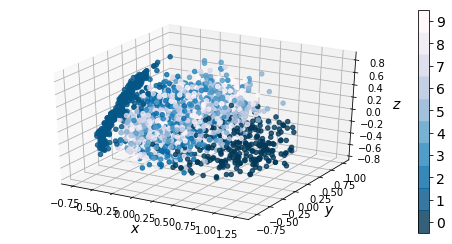

In [50]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7,3.5))
ax3d = fig.add_subplot(111, projection='3d')

colors = y_batch# / 9.0
colormap = plt.get_cmap('PuBu_r', 10)

p = ax3d.scatter3D(
        X3d[:, 0], X3d[:, 1], X3d[:, 2],
        c=colors, cmap=colormap, marker='o', alpha=0.8
)

ax3d.set_xlabel("$x$", fontsize=14)
ax3d.set_ylabel("$y$", fontsize=14)
ax3d.set_zlabel("$z$", fontsize=14)
ax3d.axis('tight')

cbar = fig.colorbar(p)
tick_labels = [d for d in range(10)]
tick_locations = []
for i in tick_labels:
    tick_locations.append(  (i + 0.5)*(9.0/10.0)  ) 
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
fig_save_path = "images/" + model_name + "_pca3d-all.png"
plt.savefig(fig_save_path, transparent=True) #dpi=100
plt.show()

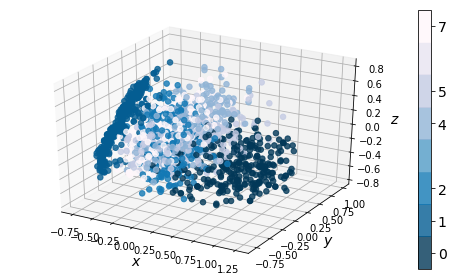

In [51]:
from mpl_toolkits.mplot3d import Axes3D

digit_list = [0, 1, 2, 4, 5, 7]

n_digits = len(digit_list)
digit_min = min(digit_list)
digit_max = max(digit_list)
digit_range = np.float(digit_max - digit_min)

n_bins = digit_range + 1
delta = digit_range/(digit_range+1.0)

index_list = []
for d in digit_list:
    index_list.append(y_batch == d)
indeces = (sum(index_list) == 1)

fig = plt.figure(figsize=(7,4))
ax3d = fig.add_subplot(111, projection='3d')

colors = y_batch[indeces]
colormap = plt.get_cmap('PuBu_r', n_bins)

p = ax3d.scatter3D(X3d[:, 0][indeces], X3d[:, 1][indeces], X3d[:, 2][indeces],
        s=30, c=colors, cmap=colormap, marker='o', alpha=0.8
)
ax3d.set_xlabel("$x$", fontsize=14)
ax3d.set_ylabel("$y$", fontsize=14)
ax3d.set_zlabel("$z$", fontsize=14)
ax3d.axis('tight')

cbar = fig.colorbar(p)
tick_labels = digit_list
tick_locations = []
for i in range(n_digits):
    tick_locations.append(  digit_min + delta/2.0 + (tick_labels[i] - digit_min) * delta  )
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
#fig_save_path = "images/" + model_name + "_pca3d-some.png"
#plt.savefig(fig_save_path, transparent=True) #dpi=100
plt.show()

`KernelPCA` gives us different kernels to work with. Here are some common kernels:
* Linear: $K(\mathbf{a}, \mathbf{b}) = \mathbf{a}^T \cdot \mathbf{b}$
* Polynomial: $K(\mathbf{a}, \mathbf{b}) = (\gamma\mathbf{a}^T \cdot \mathbf{b} + r)^d$
* Gaussian RBF: $K(\mathbf{a}, \mathbf{b}) = \exp(-\gamma \|\mathbf{a}^T - \mathbf{b}\|^2)$
* Sigmoid: $K(\mathbf{a}, \mathbf{b}) = \tanh(\gamma\mathbf{a}^T \cdot \mathbf{b} + r)$

Options:
* `n_components` : int, default=None
* `kernel=` : “linear” | “poly” | “rbf” | “sigmoid” | “cosine” | “precomputed”
* `gamma` : float, default=1/n_features
* `degree` : int, default=3 (for poly kernels)
* `coef0` : float, default=1 (independent term in poly and sigmoid kernels, ignored by other kernels)


In [52]:
from sklearn.decomposition import KernelPCA

pca = KernelPCA(n_components=3, kernel='rbf', gamma=0.18, degree=2, random_state=2)
X3d = pca.fit_transform(X_enc)
print("Compressed", X_enc.shape, "into", X3d.shape)

Compressed (3000, 16) into (3000, 3)


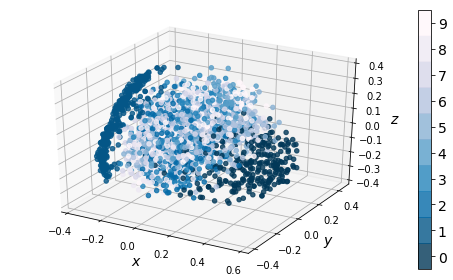

In [53]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7,4))
ax3d = fig.add_subplot(111, projection='3d')

colors = y_batch# / 9.0
colormap = plt.get_cmap('PuBu_r', 10)

p = ax3d.scatter3D(X3d[:, 0], X3d[:, 1], X3d[:, 2],
        c=colors, cmap=colormap, marker='o', alpha=0.8
)

ax3d.set_xlabel("$x$", fontsize=14)
ax3d.set_ylabel("$y$", fontsize=14)
ax3d.set_zlabel("$z$", fontsize=14)
ax3d.axis('tight')

cbar = fig.colorbar(p)
tick_labels = [d for d in range(10)]
tick_locations = []
for i in tick_labels:
    tick_locations.append(  (i + 0.5)*(9.0/10.0)  ) 
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
fig_save_path = "images/" + model_name + "_kerpca3d-all.png"
plt.savefig(fig_save_path, transparent=True) #dpi=100
plt.show()

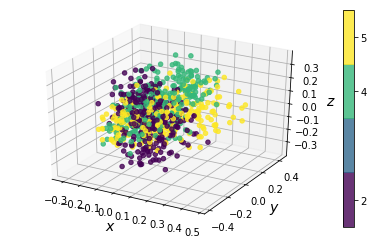

In [54]:
from mpl_toolkits.mplot3d import Axes3D

digit_list = [2, 4, 5]

n_digits = len(digit_list)
digit_min = min(digit_list)
digit_max = max(digit_list)
digit_range = np.float(digit_max - digit_min)

n_bins = digit_range + 1
delta = digit_range/(digit_range+1.0)

index_list = []
for d in digit_list:
    index_list.append(y_batch == d)
indeces = (sum(index_list) == 1)

fig = plt.figure(figsize=(7,4))
ax3d = fig.add_subplot(111, projection='3d')

colors = y_batch[indeces]
colormap = plt.get_cmap('viridis', n_bins)

p = ax3d.scatter3D(X3d[:, 0][indeces], X3d[:, 1][indeces], X3d[:, 2][indeces],
        c=colors, cmap=colormap, marker='o', alpha=0.8
)
ax3d.set_xlabel("$x$", fontsize=14)
ax3d.set_ylabel("$y$", fontsize=14)
ax3d.set_zlabel("$z$", fontsize=14)
ax3d.axis('tight')

cbar = fig.colorbar(p)
tick_labels = digit_list
tick_locations = []
for i in range(n_digits):
    tick_locations.append(  digit_min + delta/2.0 + (tick_labels[i] - digit_min) * delta  )
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()

# Variational Autoencoders

## VAE `k_vae0` (MNIST)

Dense model. The learned parameters are $param_0 = \mu$ and $param_1 = \sigma$.

In [96]:
from keras import backend as K
from keras.models import Model
from keras.engine.input_layer import Input
from keras.layers.core import Activation, Dense, Flatten, Reshape, Lambda

n_codings = 30
model_name = 'k_vae0'

encoder_file = 'models/auto/mnist/' + model_name + '-enc'
decoder_file = 'models/auto/mnist/' + model_name + '-dec'
model_file = 'models/auto/mnist/' + model_name + '-model'
image_save_path = "images/mnist/" + model_name + "/" 

### Encoder

In [98]:
K.clear_session()
n_inputs = height * width * channels

def sampling(args):
    param0, param1 = args
    batch_size = K.shape(param0)[0]
    dim = K.int_shape(param0)[1]
    normal_01 = K.random_normal(shape=(batch_size, dim))
    return param0 + param1 * normal_01


# Build the encoder part of the model
#
inputs = Input(shape=(height, width, channels,), name='inputs')
inputs_flat = Flatten()(inputs)
hidden1 = Dense(units=250, activation='relu')(inputs_flat)

param0 = Dense(n_codings, name='param0')(hidden1)
param1 = Dense(n_codings, name='param1')(hidden1)

# We feed the param0 and param1 into the Lambda layer, whose function is to 
# tranform a standard normal variable
codings = Lambda(sampling, output_shape=(n_codings,), name='codings')([param0, param1])

encoder = Model(inputs, [codings, param0, param1], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           inputs[0][0]                     
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 250)          196250      flatten_1[0][0]                  
__________________________________________________________________________________________________
param0 (Dense)                  (None, 30)           7530        dense_1[0][0]                    
__________________________________________________________________________________________________
param1 (De

### Decoder

In [99]:
# Build the decoder part of the model
#
n_outputs = n_inputs

latent_inputs = Input(shape=(n_codings,), name='latent_inputs')
hidden2 = Dense(320, activation='relu')(latent_inputs)
output_flat = Dense(units=n_outputs, activation='sigmoid')(hidden2)

output = Reshape(target_shape=(height,width,channels,), name='output')(output_flat)

decoder = Model(latent_inputs, output, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent_inputs (InputLayer)   (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 320)               9920      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               251664    
_________________________________________________________________
output (Reshape)             (None, 28, 28, 1)         0         
Total params: 261,584
Trainable params: 261,584
Non-trainable params: 0
_________________________________________________________________


In [100]:
# Stack the two together
#
outputs = decoder(  encoder(inputs)[0]  )
vae = Model(inputs, outputs, name='vae')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 30), (None, 30),  211310    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         261584    
Total params: 472,894
Trainable params: 472,894
Non-trainable params: 0
_________________________________________________________________


### Loss and Optimizer

In [101]:
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.losses import mse, binary_crossentropy

# Calculate the reconstruction loss. We use MSE. Note that since inputs/outputs are of
# shape (?, 28, 28, 1), we cannot simply call mse(inputs, outputs) as this would result
# in the MSE being calculated only along the last axis=-1, instead of over the entire image
#
# Fix: we use the backend to write the MSE explicitly
#
print("inputs/outputs shapes:", inputs.shape, outputs.shape)
reconstruction_loss = K.sum(K.square(outputs - inputs), axis=[1, 2, 3])
#reconstruction_loss *= n_inputs
print("rec_loss:", reconstruction_loss.shape)


# Calculate the distribution loss (KL-div for Gaussian has a closed form)
#
eps = 1e-10
dist_loss = K.square(param0) + K.square(param1) - 1 - K.log( eps + K.square(param1) )
dist_loss = 0.5 * K.sum(dist_loss, axis=-1)
print("dist_loss:", dist_loss.shape)

loss = K.mean(reconstruction_loss + dist_loss)
#loss = K.mean(reconstruction_loss)
#loss = K.mean(dist_loss)
print("loss:", loss.shape)

optimizer = Adam()

encoder.compile(loss='binary_crossentropy', optimizer="adam")
decoder.compile(loss='binary_crossentropy', optimizer="adam")
vae.add_loss(loss)
vae.compile(optimizer=optimizer)
vae.summary()

inputs/outputs shapes: (?, 28, 28, 1) (?, 28, 28, 1)
rec_loss: (?,)
dist_loss: (?,)
loss: ()
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 30), (None, 30),  211310    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         261584    
Total params: 472,894
Trainable params: 472,894
Non-trainable params: 0
_________________________________________________________________


### Train / Save / Restore

In [102]:
n_epochs = 50
batch_size = 250
n_batches = X_train.shape[0] // batch_size

print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)

history = vae.fit(
    X_train, batch_size=batch_size, epochs=n_epochs, verbose=1
)

print("Training finished.")

Training for 50 epochs with 240 batches of size 250
Epoch 1/50
60000/60000 [==============================] - 3s 43us/step - loss: 62.7774
Epoch 2/50
60000/60000 [==============================] - 2s 29us/step - loss: 43.9824
Epoch 3/50
60000/60000 [==============================] - 2s 27us/step - loss: 39.8329
Epoch 4/50
60000/60000 [==============================] - 2s 26us/step - loss: 36.7695
Epoch 5/50
60000/60000 [==============================] - 2s 26us/step - loss: 35.2350
Epoch 6/50
60000/60000 [==============================] - 2s 27us/step - loss: 34.2340
Epoch 7/50
60000/60000 [==============================] - 2s 26us/step - loss: 33.5497
Epoch 8/50
60000/60000 [==============================] - 2s 26us/step - loss: 33.0067
Epoch 9/50
60000/60000 [==============================] - 2s 27us/step - loss: 32.6271
Epoch 10/50
60000/60000 [==============================] - 2s 26us/step - loss: 32.3018
Epoch 11/50
60000/60000 [==============================] - 2s 26us/step - los

In [ ]:
start_fresh = True
next_pid = 1

n_epochs = 50
batch_size = 250
save_every_epoch = False
save_epoch_freq = 5

rows = 3
cols = 8
n_examples = rows * cols
image_save_denominator = 10 #save every 1/n percent of an epoch

n_batches = X_train.shape[0] // batch_size

print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)

if start_fresh:
    pic_epoch_id = 0
    noise_const = np.random.normal(0, 1, n_examples * n_codings).reshape((n_examples, n_codings))
else:
    pic_epoch_id = next_pid
    #generator.load_weights(gen_file + "." + str(next_pid-1))
    #discriminator.load_weights(disc_file + "." + str(next_pid-1))
    #generator.load_weights(gen_file + ".h5")#generator.load_weights(gen_file + ".h5")
    #discriminator.load_weights(disc_file + ".h5")
    try:
        noise_const
    except NameError:
        noise_const = np.random.normal(0, 1, n_examples * n_codings).reshape((n_examples, n_codings))

epoch = pic_epoch_id
max_epoch = n_epochs + pic_epoch_id

while epoch < max_epoch:
    losses = []
    for iteration in range(n_batches):
        X_batch = random_batch_1d(X_train, batch_size)
        
        loss = vae.train_on_batch(X_batch, None)
        losses.append(loss)
        loss_sdev = np.std(losses)
        
        if iteration % max(1, n_batches // image_save_denominator) == 0:
            fake_images = decoder.predict(noise_const, verbose=0)
            image = combine_images(fake_images, rows, cols)
            image = image * 255
            Image.fromarray(image.astype(np.uint8)).save(
                image_save_path + str(epoch) + "_" + str(100 * iteration // n_batches) + ".png")
        
        if iteration % max(1, n_batches // 100) == 0:
            print("\rEpoch {:3}: {:3}% | loss: {:2.4f} | sdev: {:2.5f}".format(
                epoch, 100 * iteration // n_batches, loss, loss_sdev), end="")
            sys.stdout.flush()
        
        
    encoder.save_weights(encoder_file + '.h5', True)
    decoder.save_weights(decoder_file + '.h5', True)
    if save_every_epoch and (epoch % save_epoch_freq == 0):
        encoder.save_weights(encoder_file + "." + str(epoch), True)
        decoder.save_weights(decoder_file + "." + str(epoch), True)
    
    print()
    epoch += 1

print("Training finished.")

In [104]:
# Save the encoder, decoder, and stacked models
#
encoder.save(encoder_file + '.h5')
decoder.save(decoder_file + '.h5')
vae.save(model_file + '.h5')

In [105]:
from keras.models import load_model

# Restore a saved model if it exists
#
encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')

outputs = decoder(  encoder(inputs)[0]  )
vae = Model(inputs, outputs, name='vae')
vae.compile(loss='binary_crossentropy', optimizer="adam")

### Reconstruction Output

Let's take a look at how well the reconstructions look:

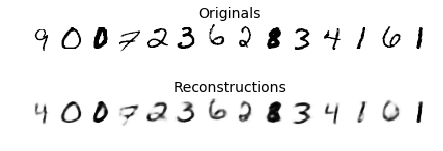

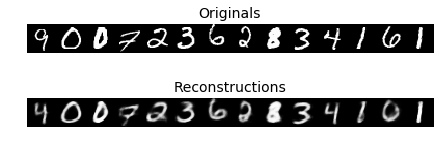

In [106]:
n_digits = 14
cols = n_digits
rows = 1
scaling_factor = 1.1

images_in = random_batch_1d(X_test, batch_size=n_digits)
images_out = vae.predict(images_in)

image_in = combine_images(images_in, rows, cols)
image_out = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(scaling_factor*cols, scaling_factor*rows*2))
plt.subplot(2,1,1)
plt.title("Originals", fontsize=14)
plt.imshow(image_in, cmap="Greys", interpolation="nearest")
plt.axis("off")

plt.subplot(2,1,2)
plt.title("Reconstructions", fontsize=14)
plt.imshow(image_out, cmap="Greys", interpolation="nearest")
plt.axis("off")

plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(scaling_factor*cols, scaling_factor*rows*2))
plt.subplot(2,1,1)
plt.title("Originals", fontsize=14)
plt.imshow(image_in, cmap="gray", interpolation="nearest")
plt.axis("off")

plt.subplot(2,1,2)
plt.title("Reconstructions", fontsize=14)
plt.imshow(image_out, cmap="gray", interpolation="nearest")
plt.axis("off")

plt.tight_layout()
plt.show()

### Encoding Distributions

In [107]:
encoder_output = encoder.predict(X_test, verbose=True)
print(encoder_output[0].shape)

10000/10000 [==============================] - 0s 46us/step
(10000, 30)


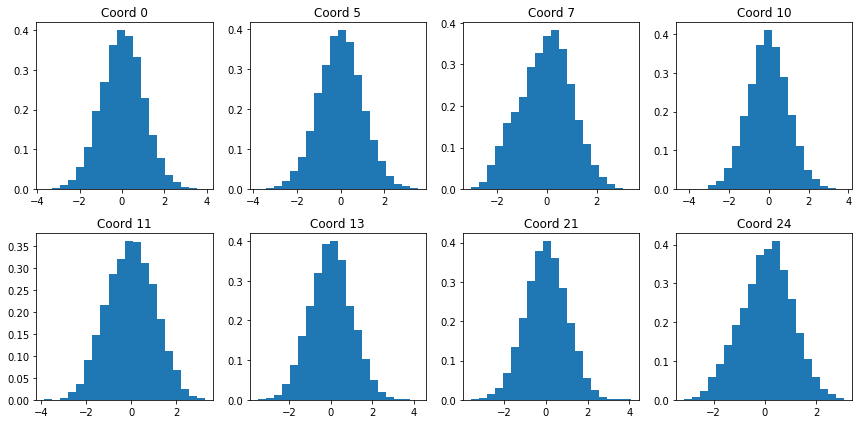

In [108]:
X_encoded = encoder_output[0]
showAll = False

coord_indeces = np.array([
    [ 0, 5, 7, 10],
    [ 11, 13, 21, 24]
])

if showAll:
    n_cols = 6
    n_rows = X_encoded.shape[1] // n_cols
else:
    n_cols = coord_indeces.shape[1]
    n_rows = coord_indeces.shape[0]

plt.figure(figsize=(12, int(12.0/n_cols * n_rows)))
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        if showAll:
            plt.title("Coord " + str(i))
            plt.hist(X_encoded[:, i], bins=20, density=True)
        else:
            plt.title("Coord " + str(coord_indeces[row, col]))
            plt.hist(X_encoded[:, coord_indeces[row, col]], bins=20, density=True)
plt.tight_layout()
plt.show()

### Generative

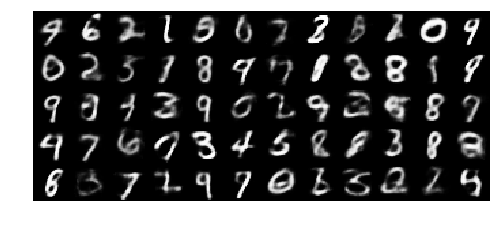

In [151]:
rows = 5
cols = 12
n_digits = rows * cols

#codings_in = np.random.uniform(-2, 2, n_digits * n_codings).reshape((n_digits, n_codings))
codings_in = np.random.normal(0, 1.0, n_digits * n_codings).reshape((n_digits, n_codings))
images_out = decoder.predict(codings_in)

image = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(0.7*cols, 0.7*rows))
plt.imshow(image, cmap="gray", interpolation='nearest')
plt.axis("off")
plt.show()

### Interpolating digits

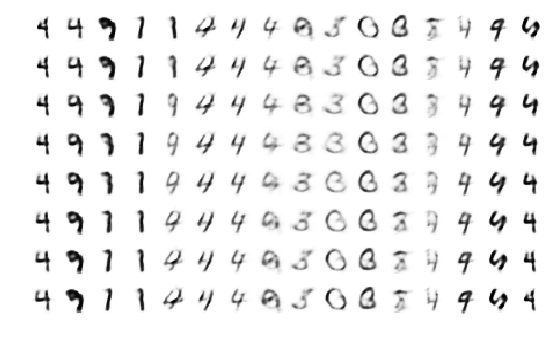

In [111]:
n_digits = 16
n_iterations = 7

#codings_in = noise = np.random.uniform(-2, 2, n_digits * n_codings).reshape((n_digits, n_codings))
codings_in = noise = np.random.normal(0, 1.0, n_digits * n_codings).reshape((n_digits, n_codings))
codings_target = target_codings = np.roll(codings_in, -1, axis=0)
difference = codings_target - codings_in

images = []

for iteration in range(n_iterations + 1):
    codings_interpolate = codings_in + difference * iteration / n_iterations
    images_out = decoder.predict(codings_interpolate)
    image = combine_images(images_out, rows=1, cols=n_digits)
    images.append(image)


fig = plt.figure(figsize=(0.8*n_digits, 0.8*n_iterations))
for i in range(n_iterations + 1):
    plt.subplot(n_iterations+1, 1, i+1)
    plt.imshow(images[i], cmap="Greys", interpolation='nearest')
    plt.axis("off")

plt.show()

Save .png images for creating gif of digit interpolations below:

In [147]:
rows = 3
cols = 7
n_digits = rows * cols
n_iterations = 15
n_targets = 5

codings_list = []
for i in range(n_targets):
    codings_list.append(np.random.normal(0, 1.0, n_digits * n_codings).reshape((n_digits, n_codings)))

image_index = 0
for coding_index in range(n_targets):
    i = 0
    codings_start = codings_list[coding_index]
    codings_end = codings_list[(coding_index + 1) % n_targets]
    delta = np.float32(codings_end - codings_start) / n_iterations
    
    while image_index < (1 + coding_index) * n_iterations:
        images_out = decoder.predict(codings_start + i*delta)
        image = combine_images(images_out, rows, cols) * 255
        file_name = "inter{:03}.png".format(image_index)
        Image.fromarray(image.astype(np.uint8)).save(
            image_save_path + file_name)
        image_index += 1
        i += 1

In [171]:
from keras.models import load_model

# Restore the regular autoencoder model
#
decoder_regular = load_model('models/auto/mnist/k_auto0-dec.h5')
n_codings = decoder_regular.layers[0].input_shape[1]

rows = 3
cols = 7
n_digits = rows * cols
n_iterations = 15
n_targets = 5

codings_list = []
for i in range(n_targets):
    codings_list.append(np.random.normal(0, 1.0, n_digits * n_codings).reshape((n_digits, n_codings)))

image_index = 0
for coding_index in range(n_targets):
    i = 0
    codings_start = codings_list[coding_index]
    codings_end = codings_list[(coding_index + 1) % n_targets]
    delta = np.float32(codings_end - codings_start) / n_iterations
    
    while image_index < (1 + coding_index) * n_iterations:
        images_out = decoder_regular.predict(codings_start + i*delta)
        image = combine_images(images_out, rows, cols) * 255
        file_name = "inter{:03}.png".format(image_index)
        Image.fromarray(image.astype(np.uint8)).save(
            'images/mnist/k_auto0/' + file_name)
        image_index += 1
        i += 1

### Random Walk

In [135]:
rows = 3
cols = 7
n_digits = rows * cols

delta = 0.15
n_iterations = 50

codings_in = np.random.normal(0, 1.0, n_digits * n_codings).reshape((n_digits, n_codings))

for i in range(n_iterations):
    images_out = decoder.predict(codings_in)
    image = combine_images(images_out, rows, cols)
    
    image = image * 255
    file_name = "walk{:03}.png".format(i)
    #print(file_name)
    Image.fromarray(image.astype(np.uint8)).save(
        image_save_path + file_name)
    
    direction_source = np.random.randint(0, 2, n_digits * n_codings).reshape((n_digits, n_codings))
    direction_plus = (direction_source == 1)
    direction_vector = 2 * direction_plus - 1
    codings_in = codings_in + delta*direction_vector

### Limited loss

Lets see what the output would be like if we only used one of the losses.

In [87]:
model_limited = Model(inputs, outputs, name='vae')

reconstruction_loss = K.sum(K.square(outputs - inputs), axis=[1, 2, 3])

eps = 1e-10
dist_loss = K.square(param0) + K.square(param1) - 1 - K.log( eps + K.square(param1) )
dist_loss = 0.5 * K.sum(dist_loss, axis=-1)

#loss = K.mean(reconstruction_loss + dist_loss)
loss = K.mean(reconstruction_loss)
#loss = K.mean(dist_loss)

optimizer = Adam()

encoder.compile(loss='binary_crossentropy', optimizer="adam")
decoder.compile(loss='binary_crossentropy', optimizer="adam")
model_limited.add_loss(loss)
model_limited.compile(optimizer=optimizer)
model_limited.summary()



n_epochs = 20
batch_size = 250
n_batches = X_train.shape[0] // batch_size

print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)
history = model_limited.fit(
    X_train, None, batch_size=batch_size, epochs=n_epochs, verbose=1
)
print("Training finished.")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 30), (None, 30),  211310    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         261584    
Total params: 472,894
Trainable params: 472,894
Non-trainable params: 0
_________________________________________________________________
Training for 20 epochs with 240 batches of size 250
Epoch 1/20
60000/60000 [==============================] - 2s 41us/step - loss: 10.1211
Epoch 2/20
60000/60000 [==============================] - 1s 25us/step - loss: 8.0729
Epoch 3/20
60000/60000 [==============================] - 2s 25us/step - loss: 7.0007
Epoch 4/20
60000/60000 [==============================] - 2s 26us/step - loss: 6.3379
Epo

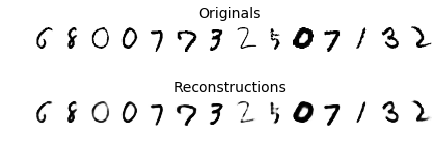

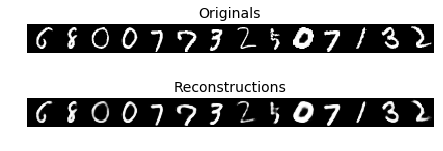

In [89]:
n_digits = 14
cols = n_digits
rows = 1
scaling_factor = 1.1

images_in = random_batch_1d(X_test, batch_size=n_digits)
images_out = model_limited.predict(images_in)

image_in = combine_images(images_in, rows, cols)
image_out = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(scaling_factor*cols, scaling_factor*rows*2))
plt.subplot(2,1,1)
plt.title("Originals", fontsize=14)
plt.imshow(image_in, cmap="Greys", interpolation="nearest")
plt.axis("off")

plt.subplot(2,1,2)
plt.title("Reconstructions", fontsize=14)
plt.imshow(image_out, cmap="Greys", interpolation="nearest")
plt.axis("off")

plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(scaling_factor*cols, scaling_factor*rows*2))
plt.subplot(2,1,1)
plt.title("Originals", fontsize=14)
plt.imshow(image_in, cmap="gray", interpolation="nearest")
plt.axis("off")

plt.subplot(2,1,2)
plt.title("Reconstructions", fontsize=14)
plt.imshow(image_out, cmap="gray", interpolation="nearest")
plt.axis("off")

plt.tight_layout()
plt.show()

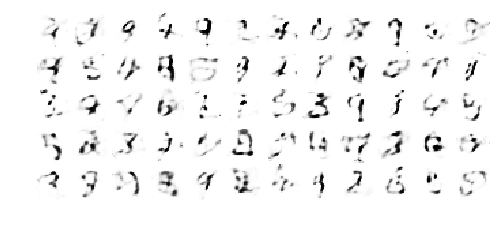

In [93]:
rows = 5
cols = 12
n_digits = rows * cols

#codings_in = np.random.uniform(-2, 2, n_digits * n_codings).reshape((n_digits, n_codings))
codings_in = np.random.normal(0, 1.0, n_digits * n_codings).reshape((n_digits, n_codings))
images_out = decoder.predict(codings_in)

image = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(0.7*cols, 0.7*rows))
plt.imshow(image, cmap="Greys", interpolation='nearest')
plt.axis("off")
plt.show()

## PCA visualization

### 2D

In [152]:
from keras.models import load_model

model_name = 'k_vae0'

encoder_file = 'models/auto/mnist/' + model_name + '-enc'
decoder_file = 'models/auto/mnist/' + model_name + '-dec'

encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')

n_codings = encoder.layers[-1].output_shape[1]
print(n_codings)

30


In [153]:
n_points = 3000
X_batch, y_batch = random_batch(X_train, y_train, n_points)
X_enc = encoder.predict(X_batch)[0]

In [154]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2d = pca.fit_transform(X_enc)
print("Compressed", X_enc.shape, "into", X2d.shape)

Compressed (3000, 30) into (3000, 2)


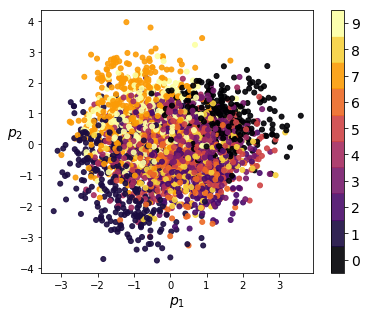

In [155]:
fig = plt.figure(figsize=(5.5,4.5))

colors = y_batch
colormap = plt.get_cmap('inferno', 10)

p = plt.scatter(X2d[:, 0], X2d[:, 1],
        s=25, c=colors, cmap=colormap, marker='o', alpha=0.9
)

plt.xlabel("$p_1$", fontsize=14)
plt.ylabel("$p_2$", fontsize=14).set_rotation(0)
plt.axis('tight')

cbar = fig.colorbar(p)
# The color bar values range from 0 to 9 (10 total values), and
# each data point should have a label located at the middle of each bin.
# The bins are: 0.5*(9.0/10.0), 1.5*(9.0/10.0), etc.
tick_labels = [d for d in range(10)]
tick_locations = []
for i in tick_labels:
    tick_locations.append(  (i + 0.5)*(9.0/10.0)  ) 
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
fig_save_path = "images/" + model_name + "_pca2d-all.png"
plt.savefig(fig_save_path, transparent=True) #dpi=100
plt.show()

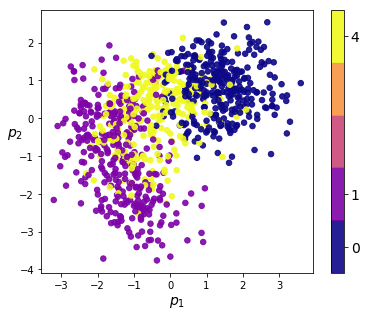

In [156]:
digit_list = [0, 1, 4]

n_digits = len(digit_list)
digit_min = min(digit_list)
digit_max = max(digit_list)
digit_range = np.float(digit_max - digit_min)

n_bins = digit_range + 1
delta = digit_range/(digit_range+1.0)

index_list = []
for d in digit_list:
    index_list.append(y_batch == d)
indeces = (sum(index_list) == 1)

plt.figure(figsize=(5.5,4.5))

colors = y_batch[indeces]
colormap = plt.get_cmap('plasma', n_bins)

p = plt.scatter(X2d[indeces, 0], X2d[indeces, 1], 
        s=30, c=colors, cmap=colormap, marker='o', alpha=0.9
)
plt.xlabel("$p_1$", fontsize=14)
plt.ylabel("$p_2$", fontsize=14).set_rotation(0)
plt.axis('tight')

cbar = plt.colorbar(p)
tick_labels = digit_list
tick_locations = []
for i in range(n_digits):
    tick_locations.append(  digit_min + delta/2.0 + (tick_labels[i] - digit_min) * delta  )
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
#fig_save_path = "images/" + model_name + "_pca2d-some.png"
#plt.savefig(fig_save_path, transparent=True) #dpi=100
plt.show()

`KernelPCA` gives us different kernels to work with. Here are some common kernels:
* Linear: $K(\mathbf{a}, \mathbf{b}) = \mathbf{a}^T \cdot \mathbf{b}$
* Polynomial: $K(\mathbf{a}, \mathbf{b}) = (\gamma\mathbf{a}^T \cdot \mathbf{b} + r)^d$
* Gaussian RBF: $K(\mathbf{a}, \mathbf{b}) = \exp(-\gamma \|\mathbf{a}^T - \mathbf{b}\|^2)$
* Sigmoid: $K(\mathbf{a}, \mathbf{b}) = \tanh(\gamma\mathbf{a}^T \cdot \mathbf{b} + r)$

Options:
* `n_components` : int, default=None
* `kernel=` : “linear” | “poly” | “rbf” | “sigmoid” | “cosine” | “precomputed”
* `gamma` : float, default=1/n_features
* `degree` : int, default=3 (for poly kernels)
* `coef0` : float, default=1 (independent term in poly and sigmoid kernels, ignored by other kernels)


In [157]:
from sklearn.decomposition import KernelPCA

pca = KernelPCA(n_components=2, kernel='poly', gamma=0.15, degree=2)
X2d = pca.fit_transform(X_enc)
print("Compressed", X_enc.shape, "into", X2d.shape)

Compressed (3000, 30) into (3000, 2)


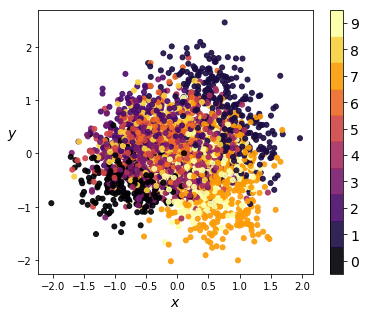

In [158]:
digit_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

n_digits = len(digit_list)
digit_min = min(digit_list)
digit_max = max(digit_list)
digit_range = np.float(digit_max - digit_min)

n_bins = digit_range + 1
delta = digit_range/(digit_range+1.0)

index_list = []
for d in digit_list:
    index_list.append(y_batch == d)
indeces = (sum(index_list) == 1)

plt.figure(figsize=(5.5, 4.5))

colors = y_batch[indeces]
colormap = plt.get_cmap('inferno', n_bins)

p = plt.scatter(X2d[indeces, 0], X2d[indeces, 1], 
        s=25, c=colors, cmap=colormap, marker='o', alpha=0.9
)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14).set_rotation(0)
#plt.xlim((-1, 1))
#plt.ylim((-1, 1))
plt.axis('tight')

cbar = plt.colorbar(p)
tick_labels = digit_list
tick_locations = []
for i in range(n_digits):
    tick_locations.append(  digit_min + delta/2.0 + (tick_labels[i] - digit_min) * delta  )
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
fig_save_path = "images/" + model_name + "_kerpca2d-all.png"
plt.savefig(fig_save_path, transparent=True) #dpi=100
plt.show()

### 3D

In [47]:
from keras.models import load_model

model_name = 'k_vae0'

encoder_file = 'models/auto/mnist/' + model_name + '-enc'
decoder_file = 'models/auto/mnist/' + model_name + '-dec'

encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')

n_codings = encoder.layers[-1].output_shape[1]
print(n_codings)

30


In [159]:
n_points = 3000
X_batch, y_batch = random_batch(X_train, y_train, n_points)
X_enc = encoder.predict(X_batch)[0]

In [160]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X3d = pca.fit_transform(X_enc)
print("Compressed", X_enc.shape, "into", X3d.shape)

Compressed (3000, 30) into (3000, 3)


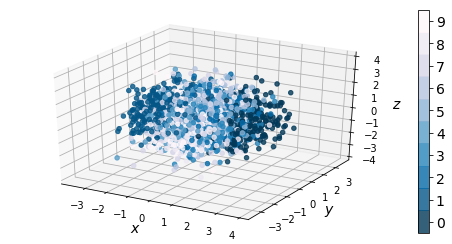

In [161]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7,3.5))
ax3d = fig.add_subplot(111, projection='3d')

colors = y_batch# / 9.0
colormap = plt.get_cmap('PuBu_r', 10)

p = ax3d.scatter3D(
        X3d[:, 0], X3d[:, 1], X3d[:, 2],
        c=colors, cmap=colormap, marker='o', alpha=0.8
)

ax3d.set_xlabel("$x$", fontsize=14)
ax3d.set_ylabel("$y$", fontsize=14)
ax3d.set_zlabel("$z$", fontsize=14)
ax3d.axis('tight')

cbar = fig.colorbar(p)
tick_labels = [d for d in range(10)]
tick_locations = []
for i in tick_labels:
    tick_locations.append(  (i + 0.5)*(9.0/10.0)  ) 
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
fig_save_path = "images/" + model_name + "_pca3d-all.png"
plt.savefig(fig_save_path, transparent=True) #dpi=100
plt.show()

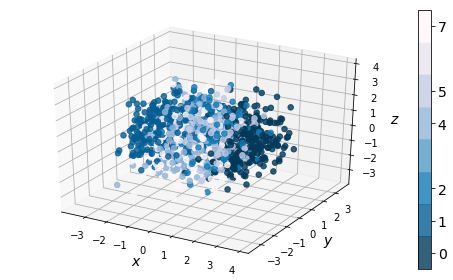

In [162]:
from mpl_toolkits.mplot3d import Axes3D

digit_list = [0, 1, 2, 4, 5, 7]

n_digits = len(digit_list)
digit_min = min(digit_list)
digit_max = max(digit_list)
digit_range = np.float(digit_max - digit_min)

n_bins = digit_range + 1
delta = digit_range/(digit_range+1.0)

index_list = []
for d in digit_list:
    index_list.append(y_batch == d)
indeces = (sum(index_list) == 1)

fig = plt.figure(figsize=(7,4))
ax3d = fig.add_subplot(111, projection='3d')

colors = y_batch[indeces]
colormap = plt.get_cmap('PuBu_r', n_bins)

p = ax3d.scatter3D(X3d[:, 0][indeces], X3d[:, 1][indeces], X3d[:, 2][indeces],
        s=30, c=colors, cmap=colormap, marker='o', alpha=0.8
)
ax3d.set_xlabel("$x$", fontsize=14)
ax3d.set_ylabel("$y$", fontsize=14)
ax3d.set_zlabel("$z$", fontsize=14)
ax3d.axis('tight')

cbar = fig.colorbar(p)
tick_labels = digit_list
tick_locations = []
for i in range(n_digits):
    tick_locations.append(  digit_min + delta/2.0 + (tick_labels[i] - digit_min) * delta  )
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
#fig_save_path = "images/" + model_name + "_pca3d-some.png"
#plt.savefig(fig_save_path, transparent=True) #dpi=100
plt.show()

`KernelPCA` gives us different kernels to work with. Here are some common kernels:
* Linear: $K(\mathbf{a}, \mathbf{b}) = \mathbf{a}^T \cdot \mathbf{b}$
* Polynomial: $K(\mathbf{a}, \mathbf{b}) = (\gamma\mathbf{a}^T \cdot \mathbf{b} + r)^d$
* Gaussian RBF: $K(\mathbf{a}, \mathbf{b}) = \exp(-\gamma \|\mathbf{a}^T - \mathbf{b}\|^2)$
* Sigmoid: $K(\mathbf{a}, \mathbf{b}) = \tanh(\gamma\mathbf{a}^T \cdot \mathbf{b} + r)$

Options:
* `n_components` : int, default=None
* `kernel=` : “linear” | “poly” | “rbf” | “sigmoid” | “cosine” | “precomputed”
* `gamma` : float, default=1/n_features
* `degree` : int, default=3 (for poly kernels)
* `coef0` : float, default=1 (independent term in poly and sigmoid kernels, ignored by other kernels)


In [168]:
from sklearn.decomposition import KernelPCA

pca = KernelPCA(n_components=3, kernel='rbf', gamma=0.12, degree=2, random_state=2)
X3d = pca.fit_transform(X_enc)
print("Compressed", X_enc.shape, "into", X3d.shape)

Compressed (3000, 30) into (3000, 3)


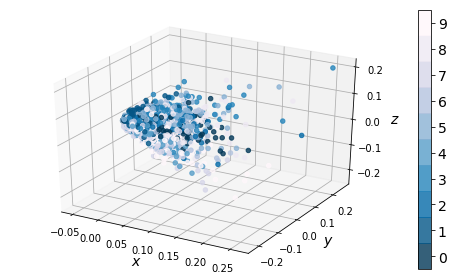

In [169]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7,4))
ax3d = fig.add_subplot(111, projection='3d')

colors = y_batch# / 9.0
colormap = plt.get_cmap('PuBu_r', 10)

p = ax3d.scatter3D(X3d[:, 0], X3d[:, 1], X3d[:, 2],
        c=colors, cmap=colormap, marker='o', alpha=0.8
)

ax3d.set_xlabel("$x$", fontsize=14)
ax3d.set_ylabel("$y$", fontsize=14)
ax3d.set_zlabel("$z$", fontsize=14)
ax3d.axis('tight')

cbar = fig.colorbar(p)
tick_labels = [d for d in range(10)]
tick_locations = []
for i in tick_labels:
    tick_locations.append(  (i + 0.5)*(9.0/10.0)  ) 
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
fig_save_path = "images/" + model_name + "_kerpca3d-all.png"
plt.savefig(fig_save_path, transparent=True) #dpi=100
plt.show()

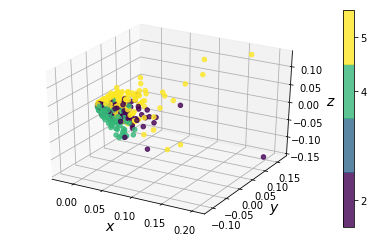

In [165]:
from mpl_toolkits.mplot3d import Axes3D

digit_list = [2, 4, 5]

n_digits = len(digit_list)
digit_min = min(digit_list)
digit_max = max(digit_list)
digit_range = np.float(digit_max - digit_min)

n_bins = digit_range + 1
delta = digit_range/(digit_range+1.0)

index_list = []
for d in digit_list:
    index_list.append(y_batch == d)
indeces = (sum(index_list) == 1)

fig = plt.figure(figsize=(7,4))
ax3d = fig.add_subplot(111, projection='3d')

colors = y_batch[indeces]
colormap = plt.get_cmap('viridis', n_bins)

p = ax3d.scatter3D(X3d[:, 0][indeces], X3d[:, 1][indeces], X3d[:, 2][indeces],
        c=colors, cmap=colormap, marker='o', alpha=0.8
)
ax3d.set_xlabel("$x$", fontsize=14)
ax3d.set_ylabel("$y$", fontsize=14)
ax3d.set_zlabel("$z$", fontsize=14)
ax3d.axis('tight')

cbar = fig.colorbar(p)
tick_labels = digit_list
tick_locations = []
for i in range(n_digits):
    tick_locations.append(  digit_min + delta/2.0 + (tick_labels[i] - digit_min) * delta  )
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()

In [5]:
print()